In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [70]:
cbr1krr = pd.read_csv('cbr1kr.csv')
hayabusa = pd.read_csv('hayabusa.csv')

cbr = cbr1krr.to_numpy()
haya = hayabusa.to_numpy()

cbr_rpm_Nm = cbr[:,[0,4]]

In [71]:
# constants
mass = 500 #kg
wheel_rad = .3 #m
rear_weight = .55 #fraction out of 1
tire_mu = 1
final_drive = 3
CG_height = .4 #m
Coef_drag = np.float64(.4)
frontal_A = np.float64(1.4) #m^2
Rho = np.float64(1.204) # kg/m^3
wheel_base = 1.8 #m
primary_reduction = 1.717
cbr_gears = np.array([2.286, 1.778, 1.5, 1.333, 1.214, 1.138])
gear = cbr_gears * primary_reduction

In [72]:
# top_speed_mph = 100
# top_speed_mps = top_speed_mph * .44704 #conversion from mph to m/s

# final_drive_ratios = np.linspace(1,8,80)
# top_speed_rpm = np.zeros_like(final_drive_ratios)

# for fd_idx, fd_val in enumerate(final_drive_ratios):
#     top_speed_rpm[fd_idx] = top_speed_mps / (2 * np.pi * wheel_rad) * fd_val * gear[5] * 60

# def final_drive_for_top_speed(top_speed_mph):
#     top_speed_mps = top_speed_mph * .44704
#     final_drive_ratio = 13000 / 60 / gear[5] * .6 * np.pi / top_speed_mps
#     return final_drive_ratio

# def top_speed_for_final_drive(final_drive): # mph
#     return 13000 / final_drive / gear[5] / 60 * .6 * np.pi / .44704
# # plt.plot(final_drive_ratios, top_speed_rpm)

In [83]:
def rpm_for_speed_gear(speed, g, fd = final_drive, WR = wheel_rad): #m/s and an int 0 - 5 for 1 - 6 gears
    revs = speed / (2 * WR * np.pi) * fd * gear[g] * 60
    return min(revs, 12800)

def calc_thrust(t, g, FD = final_drive, WR = wheel_rad):
    return t * gear[g] * FD / WR

def calc_drag(v, rho = Rho, FA = frontal_A, Cd = Coef_drag):
    return np.float64((v*v) * rho * Cd * FA / 2)

def calc_rear_tire_NL(accel, CG = CG_height, m = mass, wb = wheel_base, rw = rear_weight):
    return ((m * CG) / wb * accel) + (m * rw)

def calc_traction(rear_NL, thrust, mu = tire_mu): # add tire model for mu later instead of constant
    return min(rear_NL * 9.8 * mu, thrust)

def calc_accel(traction, drag, m = mass):
    return (traction - drag) / m

def speed_for_rpm_gear(rpm, g, FD = final_drive, WR = wheel_rad):
    return rpm / FD / gear[g] * (2* WR * np.pi) / 60

def cbr_torque_for_rpm(rpm):
    return np.float64((-0.000002458755 * (rpm*rpm)) + (0.0489652485446 * rpm) - 129.1573667711599)

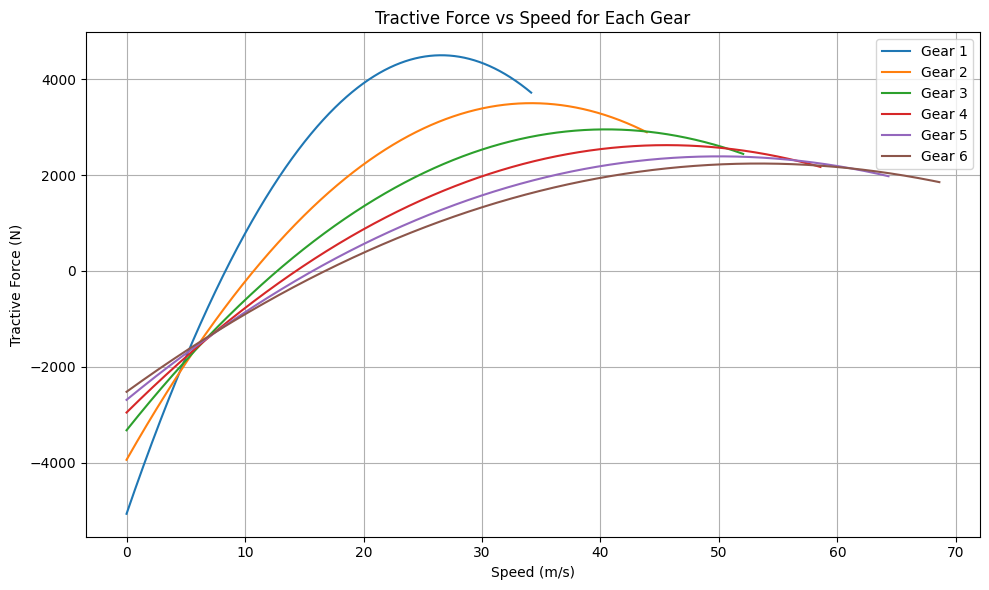

In [84]:
#shift point finder
rpms = np.linspace(0,12800,12800)
tractive_forces = [np.zeros([12800,2]) for _ in range(6)]
for g in range(6):
    for i,r in enumerate(rpms):
        tractive_forces[g][i,0] = speed_for_rpm_gear(r,g)
        # torque = np.interp(r, cbr_rpm_Nm[:,0], cbr_rpm_Nm[:,1])
        torque = cbr_torque_for_rpm(r)
        tractive_forces[g][i,1] = calc_thrust(torque,g)

labels = [f"Gear {g+1}" for g in range(6)]

# Plotting
plt.figure(figsize=(10, 6))

for g in range(6):
    if tractive_forces[g].any():  # Skip if array is all zeros (not computed)
        x = tractive_forces[g][:, 0]  # speed
        y = tractive_forces[g][:, 1]  # tractive force
        plt.plot(x, y, label=labels[g])

plt.xlabel('Speed (m/s)')  # Adjust units as appropriate
plt.ylabel('Tractive Force (N)')
plt.title('Tractive Force vs Speed for Each Gear')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [85]:
#accel calc
time = np.linspace(0,60,6001, dtype = np.float64)
dt = .01 #sec
vel = np.zeros_like(time, dtype = np.float64)
pos = np.zeros_like(time)
rpm = np.zeros_like(time, dtype = np.float64)
torque = np.zeros_like(time)
thrust = np.zeros_like(time)
drag = np.zeros_like(time)
rear_NL = np.zeros_like(time)
accel = np.zeros_like(time)
traction = np.zeros_like(time)

g = 0 # first gear 0 indexed
shift_rpm = np.float64(12800)
time_since_shift = 1 #sec, not 0 bc dont want to set 0 torque from launch
shift_time = .2
launch_rpm = np.float64(10000)

for i, t in enumerate(time[:-1]):
    rpm[i] = rpm_for_speed_gear(vel[i], g)
    
    if rpm[i] > shift_rpm and (g < 5):
        g += 1
        time_since_shift = 0
        # print("shifted")
        
    if time_since_shift < shift_time:
        torque[i] = 0
    else:
        # torque[i] = np.interp(rpm[i], cbr_rpm_Nm[:,0], cbr_rpm_Nm[:,1])
        torque[i] = cbr_torque_for_rpm(rpm[i])

    if (rpm[i] < launch_rpm) and g == 0:
        # torque[i] = np.interp(launch_rpm, cbr_rpm_Nm[:,0], cbr_rpm_Nm[:,1])
        torque[i] = cbr_torque_for_rpm(launch_rpm)
        rpm[i] = launch_rpm

    thrust[i] = calc_thrust(torque[i], g)
    drag[i] = calc_drag(vel[i])

    if i == 0:
        prev_accel = 0 
    else:
        prev_accel = accel[i-1]

    rear_NL[i] = calc_rear_tire_NL(prev_accel)
    traction[i] = calc_traction(rear_NL[i], thrust[i])
    accel[i] = calc_accel(traction[i], drag[i])
    vel[i+1] = vel[i] + (accel[i] * dt)
    pos[i+1] = pos[i] + (vel[i] * dt)
    
    time_since_shift += dt

/var/folders/yy/pf4q99nj3xz08nmtxj05kndr0000gn/T/ipykernel_38068/2712471533.py:24: RuntimeWarning: overflow encountered in scalar multiply
  return np.float64((-0.000002458755 * (rpm*rpm)) + (0.0489652485446 * rpm) - 129.1573667711599)
/var/folders/yy/pf4q99nj3xz08nmtxj05kndr0000gn/T/ipykernel_38068/2712471533.py:9: RuntimeWarning: overflow encountered in scalar multiply
  return np.float64((v*v) * rho * Cd * FA / 2)


In [86]:
def plot_simulation_results(time, vel, pos, rpm, torque, thrust, drag, rear_NL, accel, traction):
    fig, axs = plt.subplots(5, 2, figsize=(15, 18))
    axs = axs.flatten()

    axs[0].plot(time, vel*2.23694)
    axs[0].set_title("Velocity (mph)")
    axs[0].set_ylabel("mph")

    axs[1].plot(time, pos)
    axs[1].set_title("Position (m)")
    axs[1].set_ylabel("m")

    axs[2].plot(time, rpm)
    axs[2].set_title("Engine RPM")
    axs[2].set_ylabel("RPM")

    axs[3].plot(time, torque)
    axs[3].set_title("Engine Torque")
    axs[3].set_ylabel("Nm")

    axs[4].plot(time, thrust)
    axs[4].set_title("Thrust")
    axs[4].set_ylabel("N")

    axs[5].plot(time, drag)
    axs[5].set_title("Aerodynamic Drag")
    axs[5].set_ylabel("N")

    axs[6].plot(time, rear_NL)
    axs[6].set_title("Rear Normal Load")
    axs[6].set_ylabel("N")

    axs[7].plot(time, accel)
    axs[7].set_title("Acceleration")
    axs[7].set_ylabel("m/s²")

    axs[8].plot(time, traction)
    axs[8].set_title("Available Traction")
    axs[8].set_ylabel("N")

    # Empty plot to keep layout clean
    axs[9].axis('off')

    for ax in axs[:9]:
        ax.set_xlabel("Time (s)")
        ax.grid(True)

    plt.tight_layout()
    plt.show()


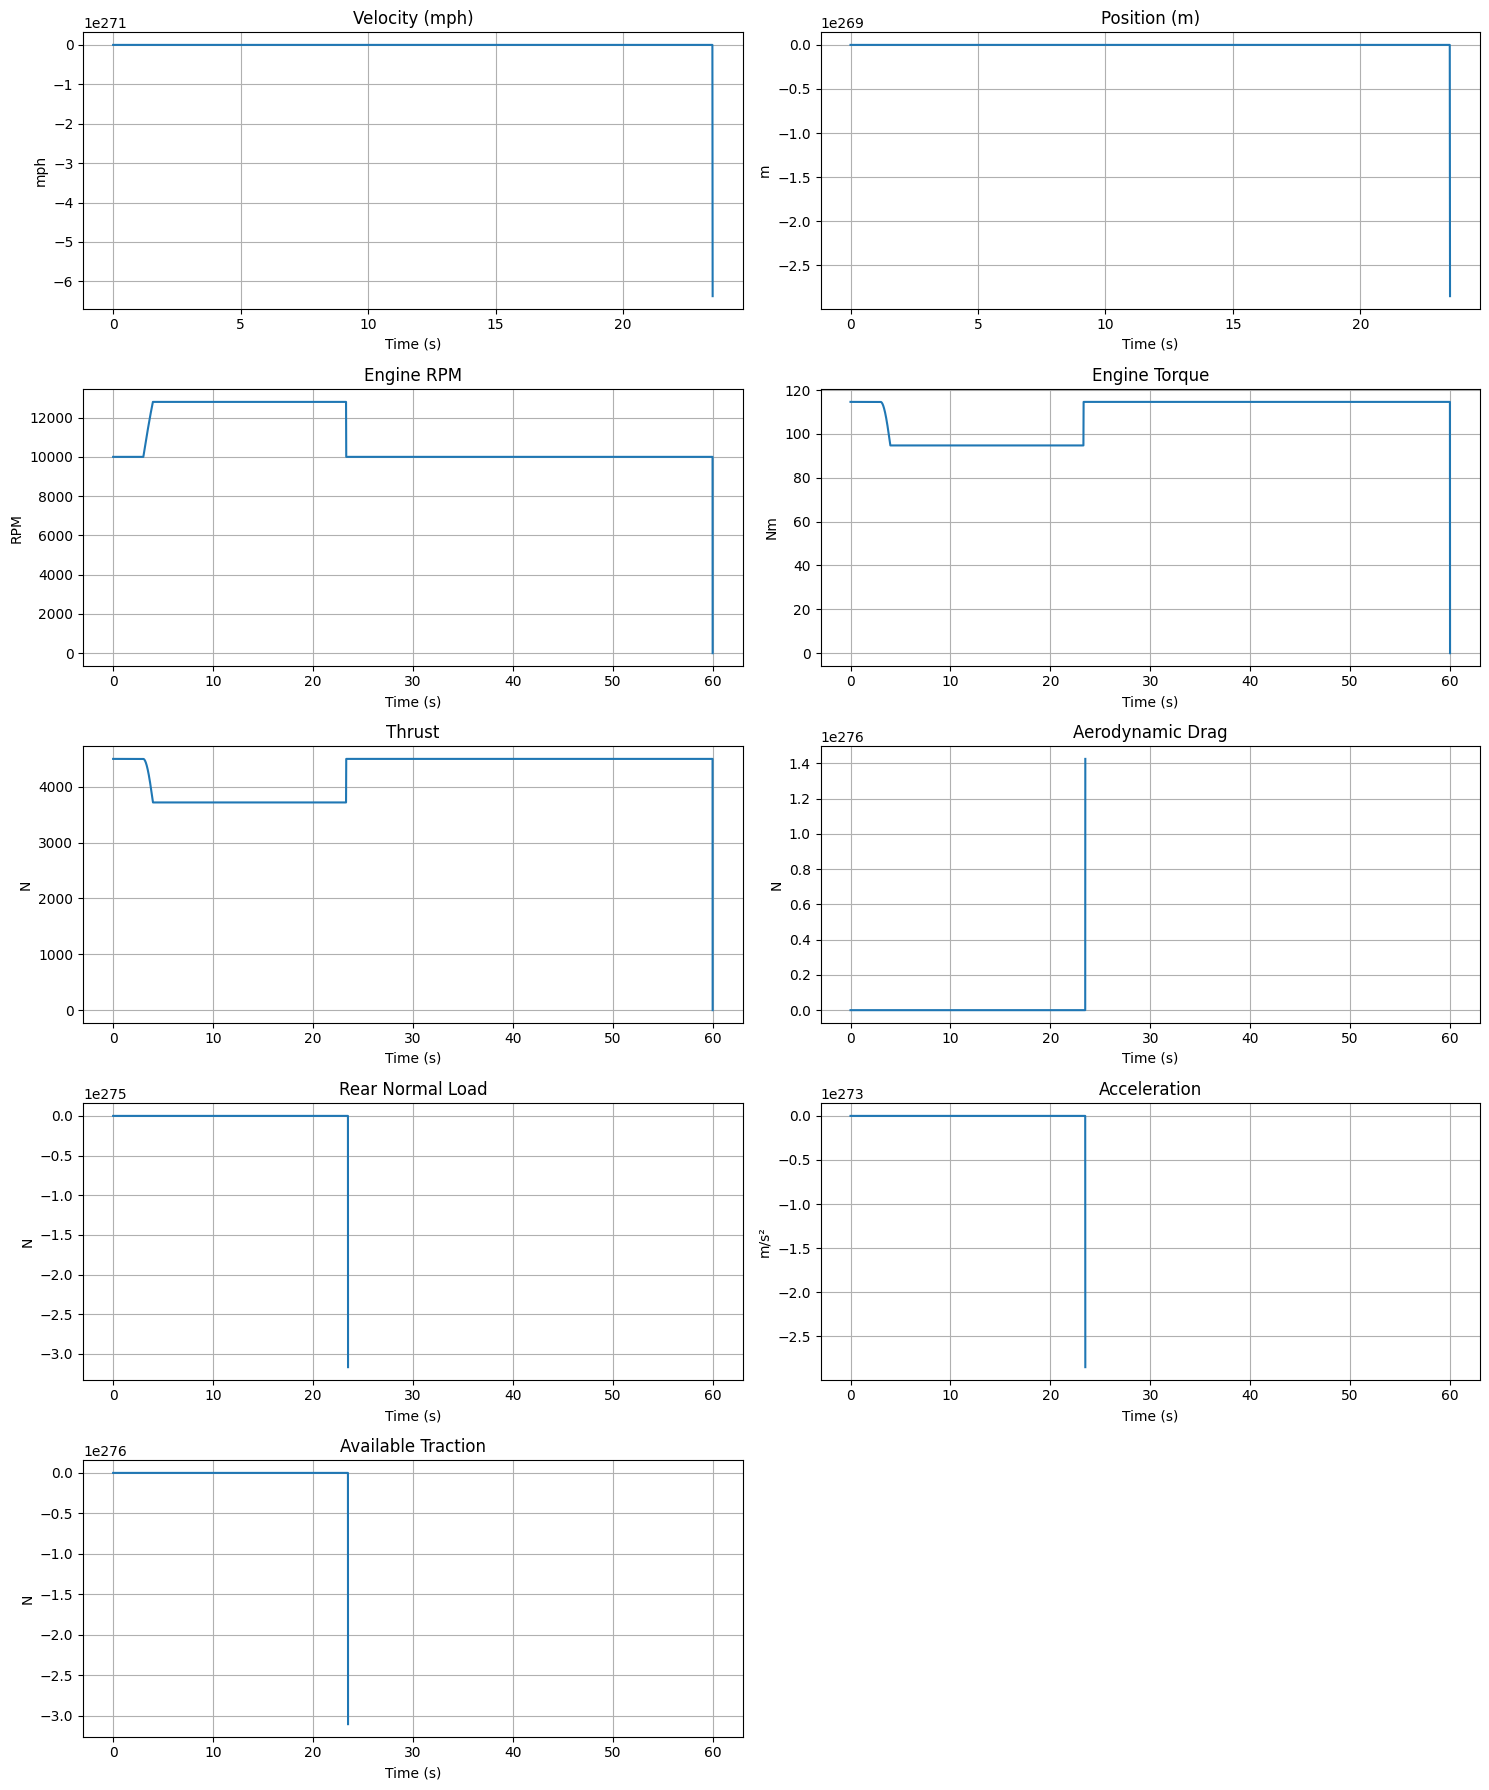

In [87]:
plot_simulation_results(time, vel, pos, rpm, torque, thrust, drag, rear_NL, accel, traction)

In [42]:
#max speed in each gear
top_speeds = np.zeros(6)
top_speeds2 = np.zeros(6)
for i in range(6):
    top_speeds[i] = 12800 / gear[i] / final_drive * (.6*np.pi) * 60 / 1609
    top_speeds2[i] = speed_for_rpm_gear(12800,i) * 2.23694

print(top_speeds)
print(top_speeds2)

[ 76.40794564  98.23878725 116.44570915 131.03418134 143.87855332
 153.48731435]
[ 76.39173994  98.21795135 116.42101166 131.00638972 143.84803748
 153.45476054]
